In [134]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import urllib.request
from bs4 import BeautifulSoup
import threading
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [2]:
#checking for missing values in columns including null values and "---"
def numberofnan(dataset):
    column_labels = dataset.columns.tolist()
    num_missingvalues = list()
    num_available = list()
    percentage_missingvalues = list()
    percentage_available_values = list()
    for column in column_labels:
        missing_val_sum = dataset[column].isna().sum() + dataset.loc[dataset[column] == "---"].shape[0]
        num_missingvalues.append(missing_val_sum)
        num_available.append(dataset[column].shape[0] - missing_val_sum)
        percentage_missingvalues.append(100*(missing_val_sum)/dataset[column].shape[0])
        percentage_available_values.append(100*(dataset[column].shape[0] - missing_val_sum)/dataset[column].shape[0])
    missing_value_percentage_df = pd.DataFrame({'Column Name':column_labels,'Number of Missing values':num_missingvalues, "Available Values":num_available,'% of missing values':percentage_missingvalues})
    return missing_value_percentage_df

In [3]:
directory_path1 = os.path.join(os.getcwd(),"Full_Data_Pack_1")
directory_path2 = os.path.join(os.getcwd(),"Full_Data_Pack_2")

In [4]:
#Data Pack 1
df_horses = pd.read_csv(os.path.join(directory_path1,"horses","horses.csv"))
df_jockeys = pd.read_csv(os.path.join(directory_path1,"jockeys","jockeys.csv"))
df_races_sectional = pd.read_csv(os.path.join(directory_path1,"races_sectional","races_sectional.csv"))
df_trainer = pd.read_csv(os.path.join(directory_path1,"trainer","trainer.csv"))
df_sectional_table = pd.read_csv(os.path.join(directory_path1,"sectional_table","sectional_table.csv"))

In [5]:
#Data Pack 2
df_records = pd.read_csv(os.path.join(directory_path2,"records","records.csv"),low_memory=False)
df_races = pd.read_csv(os.path.join(directory_path2,"races","races.csv"),low_memory=False)

In [6]:
df_records.shape

(311073, 22)

In [7]:
""" race_grouped = df_records.groupby("Race_ID")
race_id_list = list()
for key,group in race_grouped:
    race_id_list.append(key) """

' race_grouped = df_records.groupby("Race_ID")\nrace_id_list = list()\nfor key,group in race_grouped:\n    race_id_list.append(key) '

In [8]:
acronym_list = ["DISQ","DNF","FE","PU","TNP","UR","VOID","WR","WV","WV-A","WX","WX-A","WXNR"]
def drop_other_acronyms(x):
    if x["Place"] not in acronym_list:
        return x
        
def parse_placings(x):
    if type(x["Place"]) == str:
        x["Place"] = int(x["Place"].split(" ")[0])
    return x

In [9]:
#remove cases where a horse had to be withdrawn due to any reason
df_records.drop(df_records[(df_records["Place"] == "DISQ")| (df_records["Place"] == "DNF") | (df_records["Place"] == "FE") \
            | (df_records["Place"] == "PU") | (df_records["Place"] == "TNP") \
            | (df_records["Place"] == "UR") | (df_records["Place"] == "VOID") \
            | (df_records["Place"] == "WR") | (df_records["Place"] == "WV") \
            | (df_records["Place"] == "WV-A") | (df_records["Place"] == "WX") \
            | (df_records["Place"] == "WX-A") | (df_records["Place"] == "WXNR")].index,axis = 0, inplace=True)

In [10]:
df_records.shape

(305415, 22)

In [11]:
df_records = df_records.apply(lambda x:parse_placings(x),axis = 1)

In [12]:
df_records.tail()

,Record_ID,Race_ID,Place,Horse_Number,Horse_ID,Horse_Code,Horse_Name,Weight,Weight_Declared,Draw,...,Place_odds,Place_Section_1,Place_Section_2,Place_Section_3,Place_Section_4,Finish_time,Jockey_ID,Jockey,Trainer_ID,Trainer
311068,358352,34989,8.0,2.0,574,D173,AMAZING ONE PLUS,130,1141,10,...,38.00,8.0,8.0,8.0,NaN,01:09.1,8,A Hamelin,1,T P Yung
311069,358353,34989,9.0,1.0,130,B190,GOLDEN DASH,133,1089,12,...,15.00,11.0,11.0,9.0,NaN,01:09.1,3605,H Bentley,6,C S Shum
311070,358354,34989,10.0,11.0,13954,E257,WAR WEAPON,114,1150,1,...,2.10,4.0,4.0,10.0,NaN,01:09.3,1,K Teetan,19,C Fownes
311071,358355,34989,11.0,12.0,1013,C271,BABY,113,1155,6,...,10.75,7.0,7.0,11.0,NaN,01:09.7,11,V Borges,12,K H Ting
311072,358356,34989,12.0,3.0,1048,C234,MR CROISSANT,130,1109,5,...,5.50,10.0,10.0,12.0,NaN,01:11.1,16,T Piccone,10,W Y So


In [13]:
df_records[df_records["Place"].isna()]

,Record_ID,Race_ID,Place,Horse_Number,Horse_ID,Horse_Code,Horse_Name,Weight,Weight_Declared,Draw,...,Place_odds,Place_Section_1,Place_Section_2,Place_Section_3,Place_Section_4,Finish_time,Jockey_ID,Jockey,Trainer_ID,Trainer
303355,349402,26033,NaN,4.0,1994,A168,CHUNG WAH SPIRIT,129,---,---,...,NaN,NaN,NaN,NaN,NaN,---,22,M Chadwick,3,C H Yip
304032,350139,26769,NaN,NaN,13966,E167,FAST N' LIVELY,127,---,---,...,NaN,NaN,NaN,NaN,NaN,---,12,M L Yeung,22,D A Hayes


In [14]:
#Only 2 values of NaN in the dataset with respect to Place, hence we drop it
df_records.dropna(subset = ["Place"],inplace = True)
df_records.tail()

,Record_ID,Race_ID,Place,Horse_Number,Horse_ID,Horse_Code,Horse_Name,Weight,Weight_Declared,Draw,...,Place_odds,Place_Section_1,Place_Section_2,Place_Section_3,Place_Section_4,Finish_time,Jockey_ID,Jockey,Trainer_ID,Trainer
311068,358352,34989,8.0,2.0,574,D173,AMAZING ONE PLUS,130,1141,10,...,38.00,8.0,8.0,8.0,NaN,01:09.1,8,A Hamelin,1,T P Yung
311069,358353,34989,9.0,1.0,130,B190,GOLDEN DASH,133,1089,12,...,15.00,11.0,11.0,9.0,NaN,01:09.1,3605,H Bentley,6,C S Shum
311070,358354,34989,10.0,11.0,13954,E257,WAR WEAPON,114,1150,1,...,2.10,4.0,4.0,10.0,NaN,01:09.3,1,K Teetan,19,C Fownes
311071,358355,34989,11.0,12.0,1013,C271,BABY,113,1155,6,...,10.75,7.0,7.0,11.0,NaN,01:09.7,11,V Borges,12,K H Ting
311072,358356,34989,12.0,3.0,1048,C234,MR CROISSANT,130,1109,5,...,5.50,10.0,10.0,12.0,NaN,01:11.1,16,T Piccone,10,W Y So


In [15]:
df_records[df_records["Place"].isna()]

,Record_ID,Race_ID,Place,Horse_Number,Horse_ID,Horse_Code,Horse_Name,Weight,Weight_Declared,Draw,...,Place_odds,Place_Section_1,Place_Section_2,Place_Section_3,Place_Section_4,Finish_time,Jockey_ID,Jockey,Trainer_ID,Trainer


In [16]:
#converting all the positions entires of Place to integer
df_records = df_records.astype({"Place":"int32"})
df_records.tail()

,Record_ID,Race_ID,Place,Horse_Number,Horse_ID,Horse_Code,Horse_Name,Weight,Weight_Declared,Draw,...,Place_odds,Place_Section_1,Place_Section_2,Place_Section_3,Place_Section_4,Finish_time,Jockey_ID,Jockey,Trainer_ID,Trainer
311068,358352,34989,8,2.0,574,D173,AMAZING ONE PLUS,130,1141,10,...,38.00,8.0,8.0,8.0,NaN,01:09.1,8,A Hamelin,1,T P Yung
311069,358353,34989,9,1.0,130,B190,GOLDEN DASH,133,1089,12,...,15.00,11.0,11.0,9.0,NaN,01:09.1,3605,H Bentley,6,C S Shum
311070,358354,34989,10,11.0,13954,E257,WAR WEAPON,114,1150,1,...,2.10,4.0,4.0,10.0,NaN,01:09.3,1,K Teetan,19,C Fownes
311071,358355,34989,11,12.0,1013,C271,BABY,113,1155,6,...,10.75,7.0,7.0,11.0,NaN,01:09.7,11,V Borges,12,K H Ting
311072,358356,34989,12,3.0,1048,C234,MR CROISSANT,130,1109,5,...,5.50,10.0,10.0,12.0,NaN,01:11.1,16,T Piccone,10,W Y So


In [17]:
df_records["Place"].value_counts()

1     25741
4     25706
2     25695
3     25688
5     25585
6     25499
7     25208
8     24677
9     23473
10    22244
11    19784
12    17793
13    10229
14     8078
99       12
47        1
Name: Place, dtype: int64

In [18]:
#removing the 99 and 47
df_records.drop(df_records[(df_records["Place"] == 99) | (df_records["Place"] == 47)].index,inplace=True,axis = 0)

In [19]:
df_records.columns.tolist()

['Record_ID',
 'Race_ID',
 'Place',
 'Horse_Number',
 'Horse_ID',
 'Horse_Code',
 'Horse_Name',
 'Weight',
 'Weight_Declared',
 'Draw',
 'Distance_Between',
 'Win_odds',
 'Place_odds',
 'Place_Section_1',
 'Place_Section_2',
 'Place_Section_3',
 'Place_Section_4',
 'Finish_time',
 'Jockey_ID',
 'Jockey',
 'Trainer_ID',
 'Trainer']

Weight : The weight the horse carried while it was racing. It included the weight of the jockey and the gears. This is not the raw weight of the horse. A horse that is highly ranked in anticipation of a race, will have more weight on it. 

Declared Weight : The raw weight of the horse, plus the Weight

In [20]:
df_records.loc[df_records["Weight_Declared"] == "---"].shape

(88029, 22)

In [21]:
#Drop the RecordID column as its not relevant
#Horse_Number will be dropped as we have Horse_Id in order to merge with the Horse attribute table

df_records.drop(labels=["Record_ID","Horse_Number"],axis = 1, inplace=True)
df_records.head()

,Race_ID,Place,Horse_ID,Horse_Code,Horse_Name,Weight,Weight_Declared,Draw,Distance_Between,Win_odds,Place_odds,Place_Section_1,Place_Section_2,Place_Section_3,Place_Section_4,Finish_time,Jockey_ID,Jockey,Trainer_ID,Trainer
0,1,1,1628,B114,SHANGHAI DRAGON,130,1186,5,-,6.6,2.400,1.0,1.0,1.0,1.0,01:36.1,1,K Teetan,1,T P Yung
1,1,2,1023,C261,MANNA FROM HEAVEN,119,1107,7,4-Mar,224,56.750,5.0,5.0,5.0,2.0,01:36.3,2,C Wong,2,K L Man
2,1,3,679,D060,SMART THINKER,126,1053,4,1/3/2004,10,3.250,8.0,8.0,8.0,3.0,01:36.4,3,N Callan,3,C H Yip
3,1,4,2090,A065,SANGRIA,128,1087,6,1/3/2004,66,17.250,12.0,11.0,9.0,4.0,01:36.4,4,B Shinn,4,D E Ferraris
4,1,5,1386,B373,CIRCUIT NUMBER ONE,131,1075,2,2/1/2002,8.3,2.825,3.0,3.0,4.0,5.0,01:36.5,5,J Moreira,5,A S Cruz


In [22]:
#Horse_Code will also be dropped as it doesnt impact the placing of the horse
df_records.drop(labels=["Horse_Code"],axis = 1, inplace=True)
df_records.head()

,Race_ID,Place,Horse_ID,Horse_Name,Weight,Weight_Declared,Draw,Distance_Between,Win_odds,Place_odds,Place_Section_1,Place_Section_2,Place_Section_3,Place_Section_4,Finish_time,Jockey_ID,Jockey,Trainer_ID,Trainer
0,1,1,1628,SHANGHAI DRAGON,130,1186,5,-,6.6,2.400,1.0,1.0,1.0,1.0,01:36.1,1,K Teetan,1,T P Yung
1,1,2,1023,MANNA FROM HEAVEN,119,1107,7,4-Mar,224,56.750,5.0,5.0,5.0,2.0,01:36.3,2,C Wong,2,K L Man
2,1,3,679,SMART THINKER,126,1053,4,1/3/2004,10,3.250,8.0,8.0,8.0,3.0,01:36.4,3,N Callan,3,C H Yip
3,1,4,2090,SANGRIA,128,1087,6,1/3/2004,66,17.250,12.0,11.0,9.0,4.0,01:36.4,4,B Shinn,4,D E Ferraris
4,1,5,1386,CIRCUIT NUMBER ONE,131,1075,2,2/1/2002,8.3,2.825,3.0,3.0,4.0,5.0,01:36.5,5,J Moreira,5,A S Cruz


In [23]:
df_records["Weight_Declared"].value_counts()

---     88029
1084     1396
1095     1394
1082     1391
1072     1383
        ...  
1351        1
888         1
1339        1
1370        1
1366        1
Name: Weight_Declared, Length: 493, dtype: int64

There are 88029 instances of "---" for weight declared. This is too much of instances to discard. Hence an approach needs to be formulated to infer the weight

In [24]:
df_records.shape

(305400, 19)

In [81]:
df_horses["Age"].value_counts()

4.0     427
5.0     326
3.0     196
6.0     178
7.0      92
8.0      24
9.0      10
2.0       8
10.0      2
Name: Age, dtype: int64

Majority of horses are in the age range of 3-5. HKJC has a rule where a horse should start racing in HK before 5. Hence a horses starting age would most probably be within 3-4. A reasonable estimate for starting age of racing in HK would be 3.0. 

In [89]:
#Create a new df with just "HorseID", "Weight", "Weight Declared", "Win Odds"
df_temp = df_records[["Race_ID","Horse_ID","Horse_Name","Weight","Weight_Declared","Win_odds","Draw","Place"]]
df_temp = df_temp.astype({"Win_odds":"float64"})
#merge race_id and race_date from df_races
df_temp = df_temp.merge(df_races[["Race_ID","Prize","Date"]],on = "Race_ID",how = "inner")
df_race_records_horse = df_temp.merge(df_horses[["Horse_ID","Age","State","Sex"]],on = "Horse_ID",how = "inner")
df_race_records_horse.head()

,Race_ID,Horse_ID,Horse_Name,Weight,Weight_Declared,Win_odds,Draw,Place,Prize,Date,Age,State,Sex
0,1,1628,SHANGHAI DRAGON,130,1186,6.6,5,1,"750,000",1/17/2021,6.0,Active,Gelding
1,152,1628,SHANGHAI DRAGON,129,1153,15.0,7,2,"750,000",11/14/2020,6.0,Active,Gelding
2,209,1628,SHANGHAI DRAGON,129,1154,4.1,7,9,"750,000",10/24/2020,6.0,Active,Gelding
3,425,1628,SHANGHAI DRAGON,123,1160,4.2,8,3,"725,000",6/14/2020,6.0,Active,Gelding
4,484,1628,SHANGHAI DRAGON,114,1165,12.0,1,3,"967,000",5/24/2020,6.0,Active,Gelding


In [90]:
""" def parse_date(x):
    x["Date"] = datetime.strptime(x["Date"],"%m/%d/%Y")
    return x

df_race_records_horse =  df_race_records_horse.apply(lambda x:parse_date(x), axis = 1)
df_race_records_horse.head() """

df_race_records_horse["Date"] = pd.to_datetime(df_race_records_horse["Date"],format="%m/%d/%Y")
df_race_records_horse.head()

,Race_ID,Horse_ID,Horse_Name,Weight,Weight_Declared,Win_odds,Draw,Place,Prize,Date,Age,State,Sex
0,1,1628,SHANGHAI DRAGON,130,1186,6.6,5,1,"750,000",2021-01-17,6.0,Active,Gelding
1,152,1628,SHANGHAI DRAGON,129,1153,15.0,7,2,"750,000",2020-11-14,6.0,Active,Gelding
2,209,1628,SHANGHAI DRAGON,129,1154,4.1,7,9,"750,000",2020-10-24,6.0,Active,Gelding
3,425,1628,SHANGHAI DRAGON,123,1160,4.2,8,3,"725,000",2020-06-14,6.0,Active,Gelding
4,484,1628,SHANGHAI DRAGON,114,1165,12.0,1,3,"967,000",2020-05-24,6.0,Active,Gelding


In [91]:
#There is no indication of when age was measured. Hence this column can be dropped as it doesnt give any concrete information
df_race_records_horse.drop(['Age'],inplace=True,axis = 1)
df_race_records_horse.head()

,Race_ID,Horse_ID,Horse_Name,Weight,Weight_Declared,Win_odds,Draw,Place,Prize,Date,State,Sex
0,1,1628,SHANGHAI DRAGON,130,1186,6.6,5,1,"750,000",2021-01-17,Active,Gelding
1,152,1628,SHANGHAI DRAGON,129,1153,15.0,7,2,"750,000",2020-11-14,Active,Gelding
2,209,1628,SHANGHAI DRAGON,129,1154,4.1,7,9,"750,000",2020-10-24,Active,Gelding
3,425,1628,SHANGHAI DRAGON,123,1160,4.2,8,3,"725,000",2020-06-14,Active,Gelding
4,484,1628,SHANGHAI DRAGON,114,1165,12.0,1,3,"967,000",2020-05-24,Active,Gelding


In [92]:
min(df_race_records_horse["Date"])

Timestamp('1979-09-22 00:00:00')

In [93]:
#Find all first race dates from active horses
#group by Horse_ID and get the age of each horse at their first race
groupby_horseid = df_race_records_horse.groupby("Horse_ID")

horse_id_list = list()
for key,group in groupby_horseid:
    horse_id_list.append(key)
#find the first race date for all the horses in the list
first_race_date = list()
for key in horse_id_list:
    temp = groupby_horseid.get_group(key)
    first_race = min(temp["Date"])
    first_race_date.append(first_race)

first_race_date_df = pd.DataFrame({"Horse_ID":horse_id_list,"First_Race_Date":first_race_date})
first_race_date_df

,Horse_ID,First_Race_Date
0,1,2020-11-29
1,2,2020-12-23
2,3,2020-11-14
3,4,2020-12-23
4,5,2020-10-18
...,...,...
13911,14140,2021-07-14
13912,14141,2021-07-04
13913,14142,2021-07-04
13914,14143,2021-07-04


In [94]:
df_race_records_horse.shape

(305400, 12)

In [95]:
df_race_records_horse = df_race_records_horse.merge(first_race_date_df, on = "Horse_ID",how = "inner")
df_race_records_horse

,Race_ID,Horse_ID,Horse_Name,Weight,Weight_Declared,Win_odds,Draw,Place,Prize,Date,State,Sex,First_Race_Date
0,1,1628,SHANGHAI DRAGON,130,1186,6.6,5,1,"750,000",2021-01-17,Active,Gelding,2018-01-28
1,152,1628,SHANGHAI DRAGON,129,1153,15.0,7,2,"750,000",2020-11-14,Active,Gelding,2018-01-28
2,209,1628,SHANGHAI DRAGON,129,1154,4.1,7,9,"750,000",2020-10-24,Active,Gelding,2018-01-28
3,425,1628,SHANGHAI DRAGON,123,1160,4.2,8,3,"725,000",2020-06-14,Active,Gelding,2018-01-28
4,484,1628,SHANGHAI DRAGON,114,1165,12.0,1,3,"967,000",2020-05-24,Active,Gelding,2018-01-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
305395,34767,14136,INESTIMABLE,125,1020,57.0,7,13,"1,000,000",2021-07-11,Active,Gelding,2021-07-11
305396,34783,14137,I BELIEVE IN MAGIC,125,1036,172.0,3,12,"1,000,000",2021-07-11,Active,Gelding,2021-07-11
305397,34839,14138,SAUVESTRE,127,1117,15.0,1,6,"1,500,000",2021-07-11,Active,Gelding,2021-07-11
305398,34868,14139,WIN WIN FIGHTER,131,1062,87.0,11,8,"1,500,000",2021-07-11,Active,Gelding,2021-07-11


As per HKJC rules, a horse needs to start racing in Hong Kong before it is 5 years old, with 

In [96]:
df_race_records_horse["Age_At_Race"] = 3 + np.floor((df_race_records_horse["Date"] - df_race_records_horse["First_Race_Date"])/np.timedelta64(1,'Y'))
df_race_records_horse

,Race_ID,Horse_ID,Horse_Name,Weight,Weight_Declared,Win_odds,Draw,Place,Prize,Date,State,Sex,First_Race_Date,Age_At_Race
0,1,1628,SHANGHAI DRAGON,130,1186,6.6,5,1,"750,000",2021-01-17,Active,Gelding,2018-01-28,5.0
1,152,1628,SHANGHAI DRAGON,129,1153,15.0,7,2,"750,000",2020-11-14,Active,Gelding,2018-01-28,5.0
2,209,1628,SHANGHAI DRAGON,129,1154,4.1,7,9,"750,000",2020-10-24,Active,Gelding,2018-01-28,5.0
3,425,1628,SHANGHAI DRAGON,123,1160,4.2,8,3,"725,000",2020-06-14,Active,Gelding,2018-01-28,5.0
4,484,1628,SHANGHAI DRAGON,114,1165,12.0,1,3,"967,000",2020-05-24,Active,Gelding,2018-01-28,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305395,34767,14136,INESTIMABLE,125,1020,57.0,7,13,"1,000,000",2021-07-11,Active,Gelding,2021-07-11,3.0
305396,34783,14137,I BELIEVE IN MAGIC,125,1036,172.0,3,12,"1,000,000",2021-07-11,Active,Gelding,2021-07-11,3.0
305397,34839,14138,SAUVESTRE,127,1117,15.0,1,6,"1,500,000",2021-07-11,Active,Gelding,2021-07-11,3.0
305398,34868,14139,WIN WIN FIGHTER,131,1062,87.0,11,8,"1,500,000",2021-07-11,Active,Gelding,2021-07-11,3.0


As Hong Kong Horse Racing uses pari mutuel betting, given the bet on a horse and the total pool of the race, the odds take a wide range of values. Hence the win odds
varies widely in each race, hence there are many outliers if we just view this attribute as a decimal odds bet.

Thus the win odds value is transformed to be a percentage of the total prize thats bet on the horse on that race, bringing the values between 0 and 100, instead of the odds being labelled as outliers.

Calculation : For a given race, the the reciprocal of the win odds are calculated. The reciprocals are summed up, then the prize money is divided by this value, to get the mondey distributed, after HKJC takes its commission. Then using the available prize money, it is split among each horse, to find the fraction of the prize(getting a value between 0 and 100)

In [86]:
#Win_odds_%
race_groupby = df_race_records_horse.groupby('Race_ID')
race_id_list = list()

for key,group in race_groupby:
    race_id_list.append(key)

In [105]:
race_ids = np.unique(df_race_records_horse["Race_ID"].tolist())
df_race_records_horse_win_perc = None
for key in race_ids:
    temp = df_race_records_horse.loc[df_race_records_horse["Race_ID"] == key]
    sum_reciprocal_win_odds = sum(((1/i) if i != 0 else 0 for i  in temp["Win_odds"].tolist()))
    available_prize_money = int(temp["Prize"].tolist()[0].replace(",",""))/sum_reciprocal_win_odds
    temp["Win_odds_%"] = available_prize_money/temp["Win_odds"]
    temp["Win_odds_%"] = temp["Win_odds_%"]/sum(temp["Win_odds_%"])
    try:
        if df_race_records_horse_win_perc == None:
            df_race_records_horse_win_perc = temp
    except:
        df_race_records_horse_win_perc = pd.concat([df_race_records_horse_win_perc,temp], axis = 0)

df_race_records_horse_win_perc

<ipython-input-105-7dfa369f8a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Win_odds_%"] = available_prize_money/temp["Win_odds"]
<ipython-input-105-7dfa369f8a48>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["Win_odds_%"] = temp["Win_odds_%"]/sum(temp["Win_odds_%"])


,Race_ID,Horse_ID,Horse_Name,Weight,Weight_Declared,Win_odds,Draw,Place,Prize,Date,State,Sex,First_Race_Date,Age_At_Race,Win_odds_%
0,1,1628,SHANGHAI DRAGON,130,1186,6.6,5,1,"750,000",2021-01-17,Active,Gelding,2018-01-28,5.0,0.122118
27,1,1023,MANNA FROM HEAVEN,119,1107,224.0,7,2,"750,000",2021-01-17,Active,Gelding,2019-02-17,4.0,0.003598
45,1,679,SMART THINKER,126,1053,10.0,4,3,"750,000",2021-01-17,Active,Gelding,2020-01-22,3.0,0.080598
60,1,2090,SANGRIA,128,1087,66.0,6,4,"750,000",2021-01-17,Active,Gelding,2016-12-17,7.0,0.012212
103,1,1386,CIRCUIT NUMBER ONE,131,1075,8.3,2,5,"750,000",2021-01-17,Active,Gelding,2019-05-01,4.0,0.097106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18574,34989,1048,MR CROISSANT,130,1109,19.0,5,12,"2,200,000",2021-07-14,Active,Gelding,2019-02-10,5.0,0.042941
20395,34989,574,AMAZING ONE PLUS,130,1141,149.0,10,8,"2,200,000",2021-07-14,Active,Gelding,2020-05-09,4.0,0.005476
21557,34989,945,SUPER WINNER,117,1199,5.5,2,6,"2,200,000",2021-07-14,Active,Gelding,2019-09-01,4.0,0.148340
304638,34989,13924,WHEN YOU BELIEVE,123,1160,6.7,7,7,"2,200,000",2021-07-14,Active,Gelding,2021-01-24,3.0,0.121772


<h3> Correlation of Age with Win_odds_% </h3>

<AxesSubplot:xlabel='Age_At_Race', ylabel='Win_odds_%'>

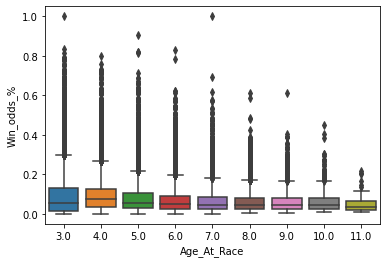

In [123]:
sns.boxplot(x = df_race_records_horse_win_perc["Age_At_Race"], y = df_race_records_horse_win_perc["Win_odds_%"])

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

' win_odds_grid = sns.FacetGrid(df_race_records_horse_win_perc,col = "Age_At_Race")\nwin_odds_grid.map(sns.distplot,"Win_odds_%",bins = 25)\nwin_odds_grid.fig.suptitle(\'Win_Odds Distribution\')\nwin_odds_grid.fig.subplots_adjust(hspace=0.9, wspace=.15)\nplt.show() '

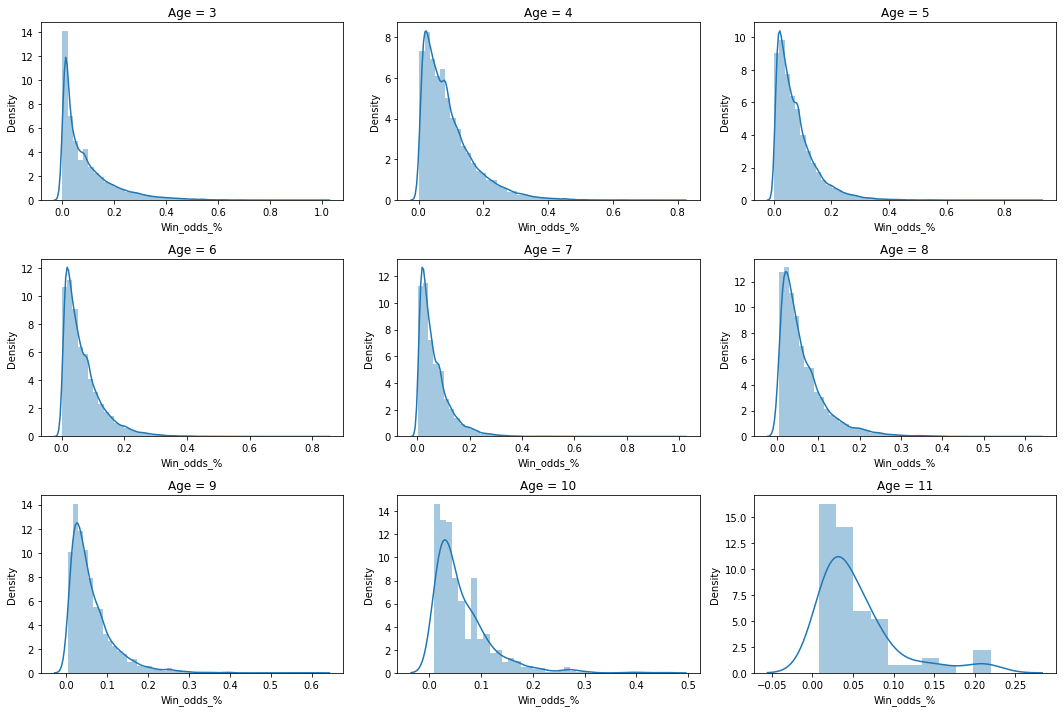

In [131]:
fig, axe = plt.subplots(3,3, figsize = (15,10))
age = 3
for i in range(3):
    for j in range(3):
            sns.distplot(df_race_records_horse_win_perc.loc[df_race_records_horse_win_perc["Age_At_Race"] == age]["Win_odds_%"], ax = axe[i,j])
            axe[i,j].set_title(f"Age = {age}")
            age += 1
fig.tight_layout()





""" win_odds_grid = sns.FacetGrid(df_race_records_horse_win_perc,col = "Age_At_Race")
win_odds_grid.map(sns.distplot,"Win_odds_%",bins = 25)
win_odds_grid.fig.suptitle('Win_Odds Distribution')
win_odds_grid.fig.subplots_adjust(hspace=0.9, wspace=.15)
plt.show() """




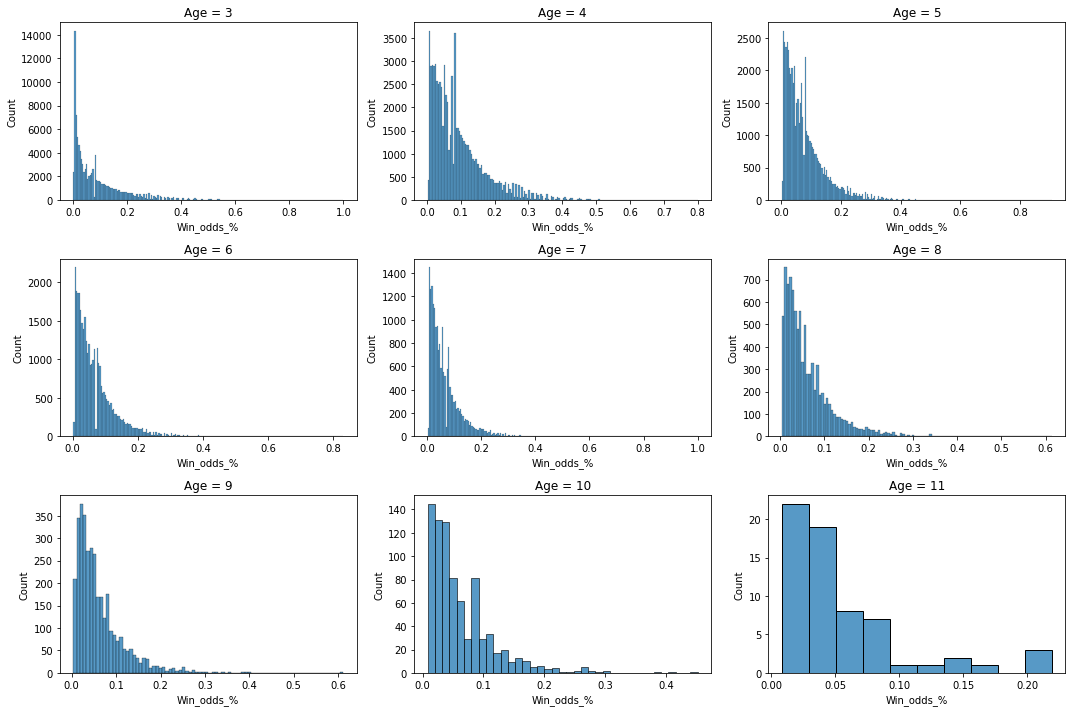

In [132]:
fig, axe = plt.subplots(3,3, figsize = (15,10))
age = 3
for i in range(3):
    for j in range(3):
            sns.histplot(df_race_records_horse_win_perc.loc[df_race_records_horse_win_perc["Age_At_Race"] == age]["Win_odds_%"], ax = axe[i,j])
            axe[i,j].set_title(f"Age = {age}")
            age += 1
fig.tight_layout()

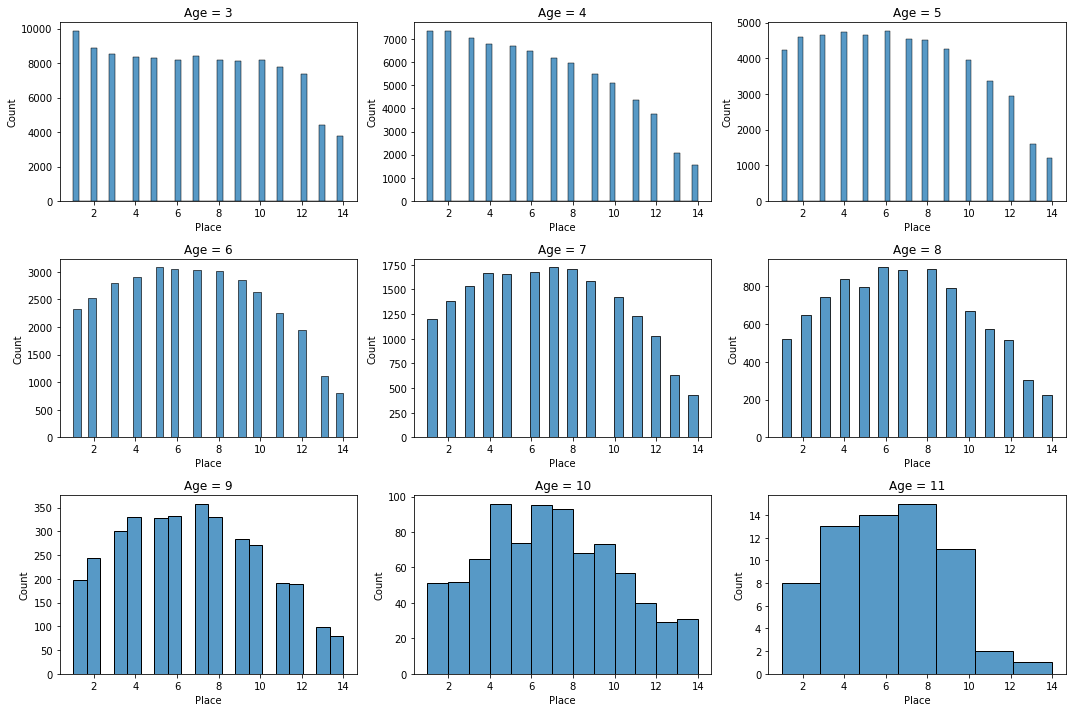

In [133]:
fig, axe = plt.subplots(3,3, figsize = (15,10))
age = 3
for i in range(3):
    for j in range(3):
            sns.histplot(df_race_records_horse_win_perc.loc[df_race_records_horse_win_perc["Age_At_Race"] == age]["Place"], ax = axe[i,j])
            axe[i,j].set_title(f"Age = {age}")
            age += 1
fig.tight_layout()

Above graphs shows that the number of high rank placings of horses decrease with increasing age. To confirm this we can use the Chi Squared Correlation, to investigate any significant correlation between Age_At_Race and Place

In [138]:
def check_chi2_correlation(contingency_table):
    DOF = (contingency_table.shape[0] - 1) * (contingency_table.shape[1] - 1)
    critical_val = chi2.ppf(0.95,DOF)
    stat,p,dof,expected_array = chi2_contingency(contingency_table)
    if stat > critical_val:
        print(f"Reject Null Hypotheses. Critical Value for 0.95 siginficance : {critical_val}, DOF : {DOF}. Chi2 statistic : {stat}")
    else:
        print(f"No correlation. Critical Value for 0.95 siginficance : {critical_val}. Chi2 statistic : {stat}")

In [135]:
#create a contingency table for 
contingency_table = pd.crosstab(df_race_records_horse_win_perc["Place"], df_race_records_horse_win_perc["Age_At_Race"])
contingency_table

Age_At_Race,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
Place,,,,,,,,,
1,9869,7346,4224,2324,1205,523,198,51,1
2,8906,7343,4589,2525,1379,651,243,52,7
3,8545,7043,4662,2789,1533,744,300,65,7
4,8339,6773,4740,2912,1668,841,331,96,6
5,8297,6698,4644,3080,1662,795,328,74,7
6,8204,6470,4765,3046,1679,901,332,95,7
7,8403,6185,4531,3024,1725,886,358,93,3
8,8197,5947,4513,3018,1703,890,329,68,12
9,8131,5500,4249,2853,1587,790,283,73,7


<h3> Observation </h3>
The above contigency table shows a clear pattern in that, as Age increases, the number of 1st Place positions decreases

In [139]:
#Finding the Critical values for a significance level of 95%
check_chi2_correlation(contingency_table)

Reject Null Hypotheses. Critical Value for 0.95 siginficance : 128.80390792721767, DOF : 104. Chi2 statistic : 2870.0824412451007


<h3> Observation </h3>
As shown from the above, there is a clear correlation between Age_At_Race and Place, as the Chi2 statistic is much greater than the critical value for 0.95 significance

<AxesSubplot:xlabel='Age_At_Race', ylabel='Win_odds_%'>

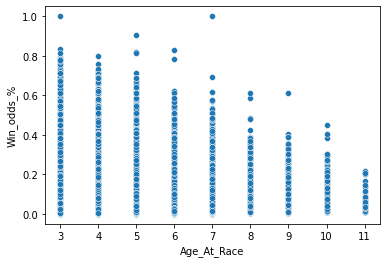

In [146]:
sns.scatterplot(x = df_race_records_horse_win_perc["Age_At_Race"],y = df_race_records_horse_win_perc["Win_odds_%"])

In [147]:
df_race_records_horse_win_perc

,Race_ID,Horse_ID,Horse_Name,Weight,Weight_Declared,Win_odds,Draw,Place,Prize,Date,State,Sex,First_Race_Date,Age_At_Race,Win_odds_%
0,1,1628,SHANGHAI DRAGON,130,1186,6.6,5,1,"750,000",2021-01-17,Active,Gelding,2018-01-28,5.0,0.122118
27,1,1023,MANNA FROM HEAVEN,119,1107,224.0,7,2,"750,000",2021-01-17,Active,Gelding,2019-02-17,4.0,0.003598
45,1,679,SMART THINKER,126,1053,10.0,4,3,"750,000",2021-01-17,Active,Gelding,2020-01-22,3.0,0.080598
60,1,2090,SANGRIA,128,1087,66.0,6,4,"750,000",2021-01-17,Active,Gelding,2016-12-17,7.0,0.012212
103,1,1386,CIRCUIT NUMBER ONE,131,1075,8.3,2,5,"750,000",2021-01-17,Active,Gelding,2019-05-01,4.0,0.097106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18574,34989,1048,MR CROISSANT,130,1109,19.0,5,12,"2,200,000",2021-07-14,Active,Gelding,2019-02-10,5.0,0.042941
20395,34989,574,AMAZING ONE PLUS,130,1141,149.0,10,8,"2,200,000",2021-07-14,Active,Gelding,2020-05-09,4.0,0.005476
21557,34989,945,SUPER WINNER,117,1199,5.5,2,6,"2,200,000",2021-07-14,Active,Gelding,2019-09-01,4.0,0.148340
304638,34989,13924,WHEN YOU BELIEVE,123,1160,6.7,7,7,"2,200,000",2021-07-14,Active,Gelding,2021-01-24,3.0,0.121772


In [157]:
df_race_records_horse_win_perc = df_race_records_horse_win_perc_backup.copy()

In [158]:
#df_race_records_horse_win_perc_backup = df_race_records_horse_win_perc.copy()
horse_id_list = np.unique(df_race_records_horse_win_perc["Horse_ID"].tolist())
df_race_records_horse_race_num = None
for horse_id in horse_id_list:
    temp = df_race_records_horse_win_perc.loc[df_race_records_horse_win_perc["Horse_ID"] == horse_id].sort_values(by = "Date")
    temp["No_Races_Competed"] = np.array(range(0,df_race_records_horse_win_perc.loc[df_race_records_horse_win_perc["Horse_ID"] == horse_id].sort_values(by = "Date").shape[0]))
    try:
        if df_race_records_horse_race_num == None:
            df_race_records_horse_race_num = temp
    except:
        df_race_records_horse_race_num = pd.concat([df_race_records_horse_race_num,temp],axis = 0)

df_race_records_horse_race_num

,Race_ID,Horse_ID,Horse_Name,Weight,Weight_Declared,Win_odds,Draw,Place,Prize,Date,State,Sex,First_Race_Date,Age_At_Race,Win_odds_%,No_Races_Competed
12829,29894,1,SUPER AXIOM,130,1243,2.2,3,1,"1,000,000",2020-11-29,Active,Gelding,2020-11-29,3.0,0.408473,0
12826,55,1,SUPER AXIOM,117,1262,1.9,4,11,"1,500,000",2020-12-23,Active,Gelding,2020-11-29,3.0,0.423203,1
12827,26842,1,SUPER AXIOM,118,1233,9.8,4,12,"1,500,000",2021-02-28,Active,Gelding,2020-11-29,3.0,0.083847,2
12828,29087,1,SUPER AXIOM,120,1239,3.9,2,8,"1,500,000",2021-04-28,Active,Gelding,2020-11-29,3.0,0.208560,3
3983,53,2,SEA ELITE,125,1176,61.0,11,12,"1,000,000",2020-12-23,Active,Gelding,2020-12-23,3.0,0.013297,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305399,34963,14140,SKY FOREVER,125,1014,116.0,9,6,"1,500,000",2021-07-14,Active,Gelding,2021-07-14,3.0,0.006993,0
305390,34466,14141,SHINING RED,121,1129,23.0,1,3,"850,000",2021-07-04,Active,Gelding,2021-07-04,3.0,0.035094,0
305391,34574,14142,NORDIC SKY,126,1002,36.0,2,13,"2,200,000",2021-07-04,Active,Colt,2021-07-04,3.0,0.022619,0
305392,34589,14143,HELENE ALLIBOR,132,1179,15.0,10,9,"1,500,000",2021-07-04,Active,Gelding,2021-07-04,3.0,0.054481,0


In [165]:
df_race_records_horse_race_num.loc[df_race_records_horse_race_num["Horse_ID"] == 7173]

,Race_ID,Horse_ID,Horse_Name,Weight,Weight_Declared,Win_odds,Draw,Place,Prize,Date,State,Sex,First_Race_Date,Age_At_Race,Win_odds_%,No_Races_Competed
106288,11906,7173,GREAT ACHIEVEMENT,116,1020,14.0,11,2,"700,000",2004-02-15,Retired,Gelding,2004-02-15,3.0,0.057936,0
106287,11812,7173,GREAT ACHIEVEMENT,116,1055,20.0,7,4,"700,000",2004-03-27,Retired,Gelding,2004-02-15,3.0,0.039996,1
106286,11792,7173,GREAT ACHIEVEMENT,117,1021,4.6,4,2,"700,000",2004-04-11,Retired,Gelding,2004-02-15,3.0,0.176028,2
106285,11722,7173,GREAT ACHIEVEMENT,117,1040,2.3,7,1,"700,000",2004-05-08,Retired,Gelding,2004-02-15,3.0,0.350670,3
106284,11660,7173,GREAT ACHIEVEMENT,115,1024,4.5,8,1,"700,000",2004-06-06,Retired,Gelding,2004-02-15,3.0,0.181929,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106219,6764,7173,GREAT ACHIEVEMENT,133,1150,41.0,12,11,"900,000",2012-01-04,Retired,Gelding,2004-02-15,10.0,0.019846,71
106218,6719,7173,GREAT ACHIEVEMENT,123,1156,8.7,1,10,"900,000",2012-01-21,Retired,Gelding,2004-02-15,10.0,0.113983,72
106217,6682,7173,GREAT ACHIEVEMENT,132,1147,66.0,8,4,"900,000",2012-02-08,Retired,Gelding,2004-02-15,10.0,0.012322,73
106216,6647,7173,GREAT ACHIEVEMENT,132,1163,22.0,6,3,"900,000",2012-02-22,Retired,Gelding,2004-02-15,11.0,0.036925,74


In [169]:
for age in np.unique(df_race_records_horse_race_num["Age_At_Race"].tolist()):
    temp = df_race_records_horse_race_num.loc[df_race_records_horse_race_num["Age_At_Race"] == age]
    contingency_table = pd.crosstab(temp["Place"],temp["No_Races_Competed"])
    print(f"Age : {age}")
    check_chi2_correlation(contingency_table)

Age : 3.0
Reject Null Hypotheses. Critical Value for 0.95 siginficance : 326.4429744210397, DOF : 286. Chi2 statistic : 2761.129230781091
Age : 4.0
Reject Null Hypotheses. Critical Value for 0.95 siginficance : 519.4339639500644, DOF : 468. Chi2 statistic : 980.2925006489721
Age : 5.0
Reject Null Hypotheses. Critical Value for 0.95 siginficance : 778.3168062565643, DOF : 715. Chi2 statistic : 914.0054097265731
Age : 6.0
Reject Null Hypotheses. Critical Value for 0.95 siginficance : 1008.2860092117248, DOF : 936. Chi2 statistic : 1054.4176984641767
Age : 7.0
No correlation. Critical Value for 0.95 siginficance : 1156.5305104162571. Chi2 statistic : 1107.8882891020178
Age : 8.0
Reject Null Hypotheses. Critical Value for 0.95 siginficance : 1344.7250610484616, DOF : 1261. Chi2 statistic : 1361.9311720966389
Age : 9.0
No correlation. Critical Value for 0.95 siginficance : 1277.567508204735. Chi2 statistic : 1251.8777669296812
Age : 10.0
No correlation. Critical Value for 0.95 siginficance 